# Metrics Classification


In [1]:
import sys, platform, numpy as np, pandas as pd
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print('Python:', sys.version.split()[0])
print('Platform:', platform.platform())
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('scikit-learn:', sklearn.__version__)


Python: 3.12.11
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
NumPy: 2.0.2
Pandas: 2.2.2
scikit-learn: 1.6.1


## 1. Configuration

In [2]:
from dataclasses import dataclass

@dataclass
class Config:
    source: str = 'sklearn'
    csv_path: str = ''
    target: str = ''
    sklearn_dataset: str = 'breast_cancer'
    test_size: float = 0.20
    val_size: float = 0.20
    random_state: int = 42
    n_jobs: int = -1

cfg = Config()
cfg

Config(source='sklearn', csv_path='', target='', sklearn_dataset='breast_cancer', test_size=0.2, val_size=0.2, random_state=42, n_jobs=-1)

## 2. Load Data

In [3]:
from sklearn.datasets import load_breast_cancer, load_wine, load_iris

def load_data(cfg: Config):
    if cfg.source == 'csv':
        assert cfg.csv_path, 'Set cfg.csv_path to your CSV file path.'
        df = pd.read_csv(cfg.csv_path)
        assert cfg.target in df.columns, 'Set cfg.target to the name of your target column.'
        X = df.drop(columns=[cfg.target])
        y = df[cfg.target]
        feature_names = X.columns.tolist()
        return X, y, feature_names
    else:
        if cfg.sklearn_dataset == 'breast_cancer':
            ds = load_breast_cancer(as_frame=True)
        elif cfg.sklearn_dataset == 'wine':
            ds = load_wine(as_frame=True)
        elif cfg.sklearn_dataset == 'iris':
            ds = load_iris(as_frame=True)
        else:
            raise ValueError('Unsupported sklearn_dataset')
        X = ds.data
        y = ds.target
        feature_names = list(X.columns)
        return X, y, feature_names

X, y, feature_names = load_data(cfg)
print('Shape:', X.shape)
display(pd.concat([X.head(), y.head()], axis=1).head())


Shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 3. Train / Validation / Test Split

In [5]:
from sklearn.model_selection import train_test_split

# First split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=cfg.test_size, stratify=y, random_state=cfg.random_state
)

# Split "train" into "train and validation"
val_ratio = cfg.val_size / (1 - cfg.test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_ratio, stratify=y_trainval, random_state=cfg.random_state
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)


Train: (341, 30) Val: (114, 30) Test: (114, 30)


## 4. Preprocessing: numeric & categorical

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_cols = X.select_dtypes(include=[float, int]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

numeric_cols, categorical_cols

(['mean radius',
  'mean texture',
  'mean perimeter',
  'mean area',
  'mean smoothness',
  'mean compactness',
  'mean concavity',
  'mean concave points',
  'mean symmetry',
  'mean fractal dimension',
  'radius error',
  'texture error',
  'perimeter error',
  'area error',
  'smoothness error',
  'compactness error',
  'concavity error',
  'concave points error',
  'symmetry error',
  'fractal dimension error',
  'worst radius',
  'worst texture',
  'worst perimeter',
  'worst area',
  'worst smoothness',
  'worst compactness',
  'worst concavity',
  'worst concave points',
  'worst symmetry',
  'worst fractal dimension'],
 [])

## 5. Models to Compare

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'LogReg': LogisticRegression(max_iter=200, n_jobs=cfg.n_jobs if hasattr(LogisticRegression(), 'n_jobs') else None),
    'SVM': SVC(kernel='rbf', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=7, n_jobs=cfg.n_jobs if hasattr(KNeighborsClassifier(), 'n_jobs') else None),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=cfg.random_state, n_jobs=cfg.n_jobs)
}
list(models.keys())

['LogReg', 'SVM', 'KNN', 'RandomForest']

## 6. Evaluation Utilities

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def make_pipeline(estimator):
    return Pipeline([
        ('preprocess', preprocess),
        ('clf', estimator)
    ])

def evaluate_model(name, estimator, X_train, y_train, X_val, y_val, X_test, y_test):
    pipe = make_pipeline(estimator)

    # Cross-validation on training data
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.random_state)
    scoring = {
        'acc': 'accuracy',
        'bal_acc': 'balanced_accuracy',
        'prec_macro': 'precision_macro',
        'rec_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    }
    cv_results = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=cfg.n_jobs, return_estimator=True)

    # Fit on train+val, evaluate on test
    pipe.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    y_proba = None
    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
        y_proba = pipe.predict_proba(X_test)
    else:
        # fallback via decision_function if available
        if hasattr(pipe.named_steps['clf'], 'decision_function'):
            scores = pipe.decision_function(X_test)
            # convert to probabilities via softmax-ish for multi-class
            if scores.ndim == 1:
                from sklearn.preprocessing import MinMaxScaler
                mm = MinMaxScaler()
                y_proba = np.c_[1 - mm.fit_transform(scores.reshape(-1,1)), mm.transform(scores.reshape(-1,1))]
            else:
                from scipy.special import softmax
                y_proba = softmax(scores, axis=1)

    y_pred = pipe.predict(X_test)

    metrics = {
        'model': name,
        'cv_acc_mean': cv_results['test_acc'].mean(),
        'cv_bal_acc_mean': cv_results['test_bal_acc'].mean(),
        'cv_f1_macro_mean': cv_results['test_f1_macro'].mean(),
        'cv_f1_weighted_mean': cv_results['test_f1_weighted'].mean(),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'test_precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'test_recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'test_f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'test_f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
    }

    # ROC-AUC OVR & PR-AUC (macro) if probabilities available
    if y_proba is not None:
        try:
            metrics['test_roc_auc_ovr_macro'] = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
        except Exception:
            metrics['test_roc_auc_ovr_macro'] = np.nan
        try:
            # For PR-AUC, need one-vs-rest binarization
            from sklearn.preprocessing import label_binarize
            classes = np.unique(y_test)
            Y_bin = label_binarize(y_test, classes=classes)
            ap_scores = []
            for i in range(Y_bin.shape[1]):
                ap_scores.append(average_precision_score(Y_bin[:, i], y_proba[:, i]))
            metrics['test_pr_auc_macro'] = float(np.mean(ap_scores))
        except Exception:
            metrics['test_pr_auc_macro'] = np.nan

    # Confusion matrix & report
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    return metrics, pipe, cm, report, y_pred, y_proba


## 7. Run Comparisons

In [10]:
from datetime import datetime

results = []
artifacts = {}
for name, est in models.items():
    m, pipe, cm, report, y_pred, y_proba = evaluate_model(name, est, X_train, y_train, X_val, y_val, X_test, y_test)
    results.append(m)
    artifacts[name] = {'pipe': pipe, 'cm': cm, 'report': report, 'y_pred': y_pred, 'y_proba': y_proba}

results_df = pd.DataFrame(results).sort_values(by='test_f1_macro', ascending=False)
display(results_df)

results_csv = 'model_results_' + datetime.now().strftime('%Y%m%d_%H%M%S') + '.csv'
results_df.to_csv(results_csv, index=False)
print('Saved:', results_csv)

,model,cv_acc_mean,cv_bal_acc_mean,cv_f1_macro_mean,cv_f1_weighted_mean,test_accuracy,test_balanced_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_f1_weighted,test_roc_auc_ovr_macro,test_pr_auc_macro
0,LogReg,0.964876,0.962662,0.962453,0.964870,0.982456,0.981151,0.981151,0.981151,0.981151,0.982456,NaN,0.422452
1,SVM,0.967690,0.964834,0.965338,0.967653,0.982456,0.981151,0.981151,0.981151,0.981151,0.982456,NaN,0.422405
2,KNN,0.970631,0.965485,0.968109,0.970414,0.973684,0.964286,0.980000,0.964286,0.971277,0.973465,NaN,0.517151
3,RandomForest,0.970673,0.965583,0.968299,0.970489,0.956140,0.950397,0.955062,0.950397,0.952638,0.956027,NaN,0.432601


Saved: model_results_20250906_015221.csv


## 8. Diagnostics for Best Model

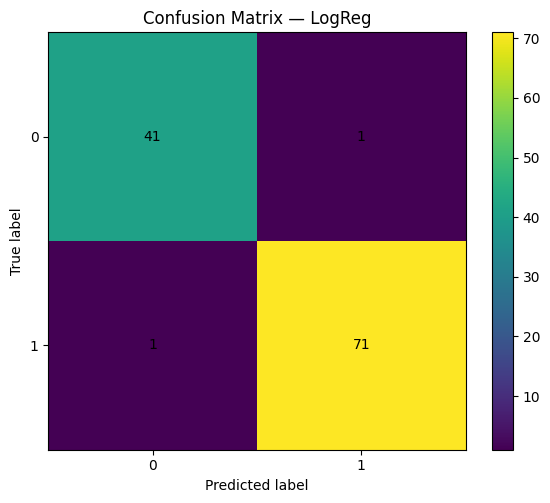


Classification report

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [11]:
best_name = results_df.iloc[0]['model']
best = artifacts[best_name]
cm = best['cm']
labels = np.unique(y_test)

fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f'Confusion Matrix — {best_name}')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center', va='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
print('\nClassification report\n')
print(best['report'])


### ROC & Precision–Recall Curves

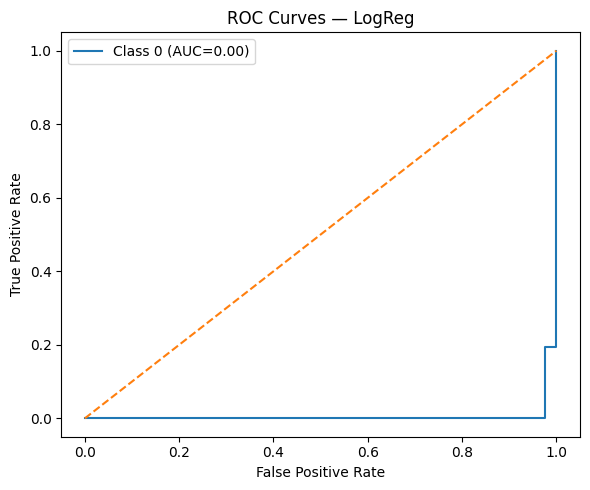

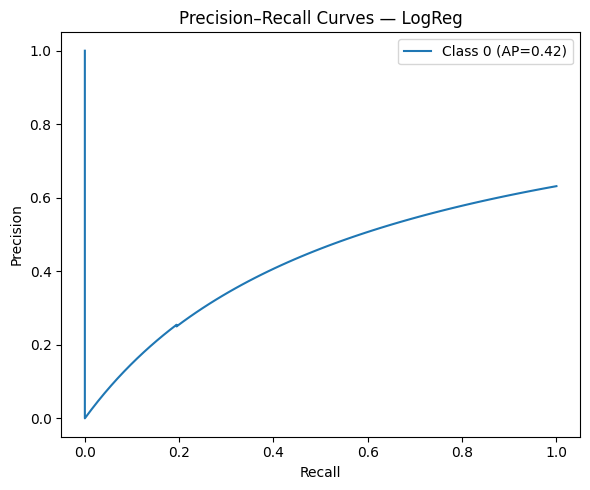

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve

y_proba = best['y_proba']
if y_proba is not None:
    classes = np.unique(y_test)
    Y_bin = label_binarize(y_test, classes=classes)
    n_classes = Y_bin.shape[1]

    # ROC curves (OvR)
    fig = plt.figure(figsize=(6,5))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(Y_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves — {best_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Precision–Recall curves (OvR)
    fig = plt.figure(figsize=(6,5))
    for i in range(n_classes):
        prec, rec, _ = precision_recall_curve(Y_bin[:, i], y_proba[:, i])
        pr_auc = auc(rec, prec)
        plt.plot(rec, prec, label=f'Class {classes[i]} (AP={pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision–Recall Curves — {best_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Best model does not provide probabilities; ROC/PR curves skipped.')


### Permutation Importance (Top Features)

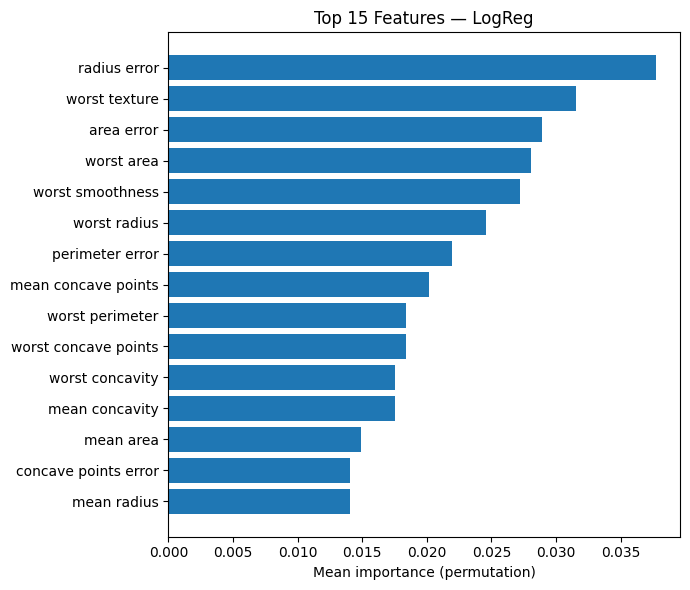

In [14]:
try:
    pipe = best['pipe']
    pipe.fit(X_trainval, y_trainval)
    r = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=cfg.random_state, n_jobs=cfg.n_jobs)
    importances = r.importances_mean

    # Get transformed feature names from preprocess
    pre = pipe.named_steps['preprocess']
    feat_names = []
    if numeric_cols:
        feat_names += numeric_cols
    if categorical_cols:
        ohe = pre.named_transformers_['cat'].named_steps['onehot']
        cat_features = ohe.get_feature_names_out(categorical_cols).tolist()
        feat_names += cat_features

    order = np.argsort(importances)[::-1]
    top_k = min(15, len(importances))
    top_idx = order[:top_k]

    fig = plt.figure(figsize=(7,6))
    plt.barh(range(top_k), importances[top_idx][::-1])
    plt.yticks(range(top_k), [feat_names[i] for i in top_idx][::-1])
    plt.xlabel('Mean importance (permutation)')
    plt.title(f'Top {top_k} Features — {best_name}')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Permutation importance could not be computed:', e)
